Let's perform EDA and basic training using data from the [IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection/) Kaggle competition.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's read the data and merge the two dataframes as specified in the competition instructions.

In [2]:
train_df = pd.read_csv("./data/train_transaction.csv")
test_df = pd.read_csv("./data/test_transaction.csv")

train_id = pd.read_csv("./data/train_identity.csv")
test_id = pd.read_csv("./data/test_identity.csv")

train_df = pd.merge(train_df, train_id, on="TransactionID", how="left")
test_df = pd.merge(test_df, test_id, on="TransactionID", how="left")

print(train_df.shape)
train_df.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


414 out of 434 columns have missing values


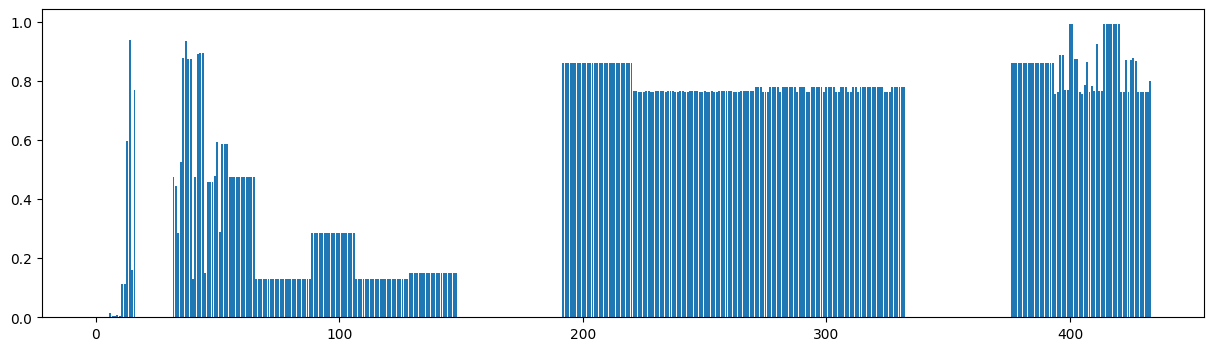

In [3]:
is_na = train_df.isna().sum() / len(train_df)

print(f"{(is_na > 0).sum()} out of {len(is_na)} columns have missing values")
plt.figure(figsize=(15, 4))
ax = plt.bar(np.arange(len(is_na)), is_na.values)

There are variables with tons of missing data. We have to acount for this when creating our models. Let's take a look at the target variable.

Train: there are 20663 frauds, 0.035 of total


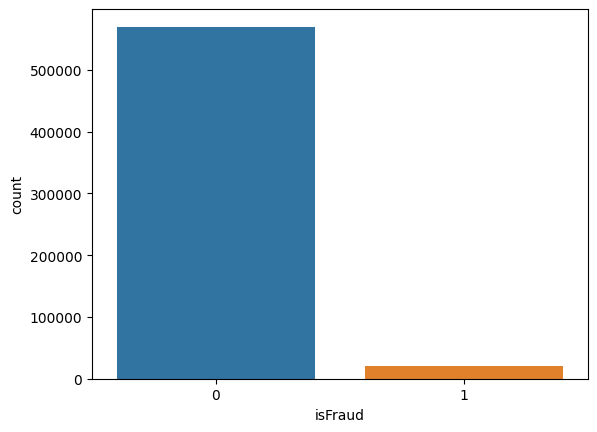

In [4]:
ax = sns.countplot(data=train_df, x="isFraud")

frauds = sum(train_df["isFraud"])
print(f"Train: there are {frauds} frauds, {frauds/len(train_df):.3f} of total")

The dataset is highly unbalanced. This is a challenge and narrows our choice of possible metrics. The competition suggests using the [ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which we'll use here.

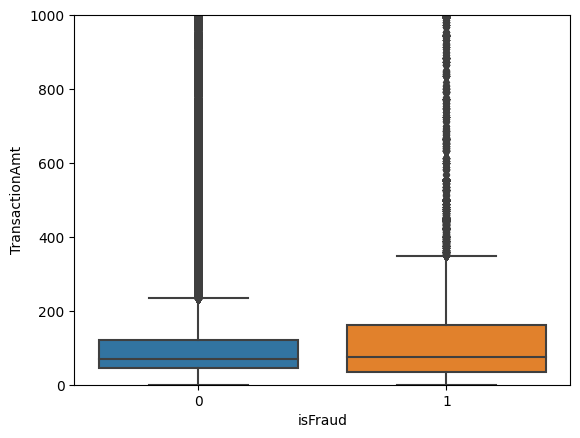

In [5]:
ax = sns.boxplot(data=train_df, x="isFraud", y="TransactionAmt")
_ = ax.set(ylim=(0, 1000))

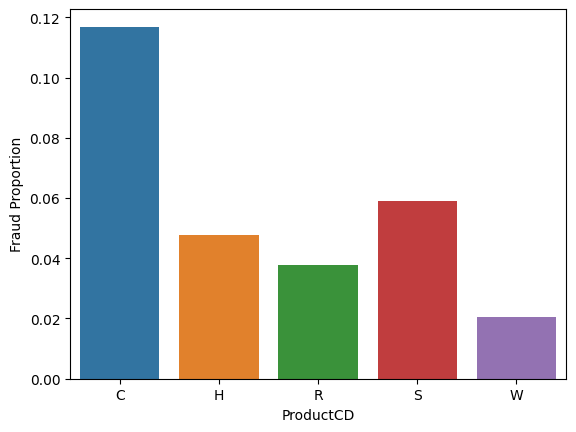

In [6]:
fraud_per_productcd = pd.DataFrame(
    {"fraud_proportion": train_df.groupby("ProductCD")["isFraud"].mean()}
)
fraud_per_productcd = fraud_per_productcd.reset_index()
fraud_per_productcd.columns = ["ProductCD", "Fraud Proportion"]

ax = sns.barplot(fraud_per_productcd, x="ProductCD", y="Fraud Proportion")

According to information available [here](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203), card1-card6 are categorical variables. Let's convert all categorical variables to their appropriate dtype.

In [7]:
categorical_cols = [
    "ProductCD", "card1", "card2", "card3", "card4", "card5", "card6",
    "addr1", "addr2", "P_emaildomain", "R_emaildomain",
    "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9",
    "DeviceType", "DeviceInfo",
    "id_12", "id_13", "id_14", "id_15", "id_16", "id_17", "id_18", "id_19",
    "id_20", "id_21", "id_22", "id_23", "id_24", "id_25", "id_26", "id_27",
    "id_28", "id_29", "id_30", "id_31", "id_32", "id_33", "id_34", "id_35",
    "id_36", "id_37", "id_38",
]

for col in categorical_cols:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = train_df[col].astype("category")

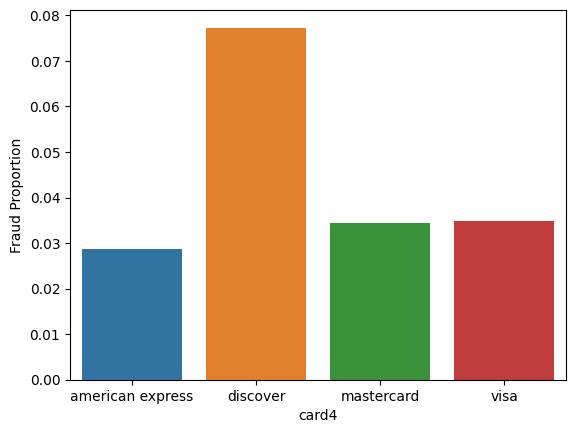

In [8]:
VARIABLE = "card4"

fraud_per_card = pd.DataFrame(
    {"fraud_proportion": train_df.groupby(VARIABLE)["isFraud"].mean()}
)
fraud_per_card = fraud_per_card.reset_index()
fraud_per_card.columns = [VARIABLE, "Fraud Proportion"]

ax = sns.barplot(fraud_per_card, x=VARIABLE, y="Fraud Proportion")

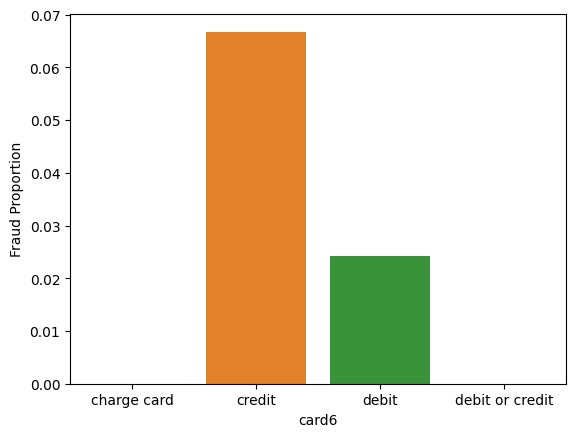

In [9]:
VARIABLE = "card6"

fraud_per_card = pd.DataFrame(
    {"fraud_proportion": train_df.groupby(VARIABLE)["isFraud"].mean()}
)
fraud_per_card = fraud_per_card.reset_index()
fraud_per_card.columns = [VARIABLE, "Fraud Proportion"]

ax = sns.barplot(fraud_per_card, x=VARIABLE, y="Fraud Proportion")

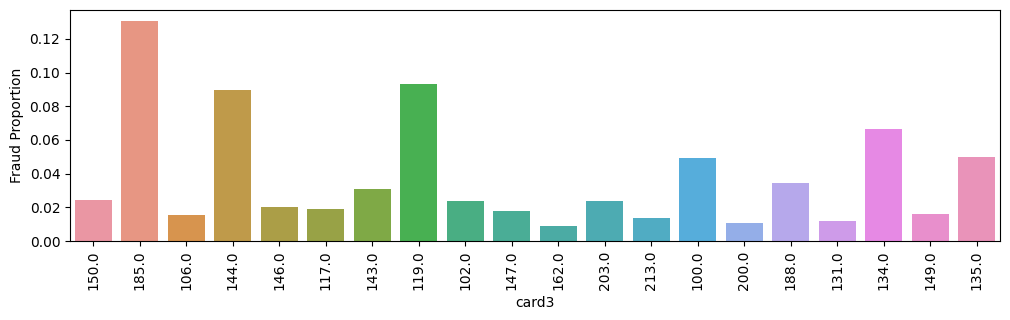

In [10]:
def plot_top_fraud_proportion(variable: str):
    fraud_per_card = train_df.groupby(variable)["isFraud"].agg(["mean", "count"])
    fraud_per_card = fraud_per_card.reset_index()
    fraud_per_card.columns = [variable, "Fraud Proportion", "Count"]
    fraud_per_card = fraud_per_card.nlargest(20, "Count")
    fraud_per_card[variable] = fraud_per_card[variable].cat.remove_unused_categories()

    plt.figure(figsize=(12, 3))
    ax = sns.barplot(data=fraud_per_card, x=variable, y="Fraud Proportion", order=fraud_per_card[variable])
    ax.tick_params(axis="x", rotation=90)

plot_top_fraud_proportion("card3")

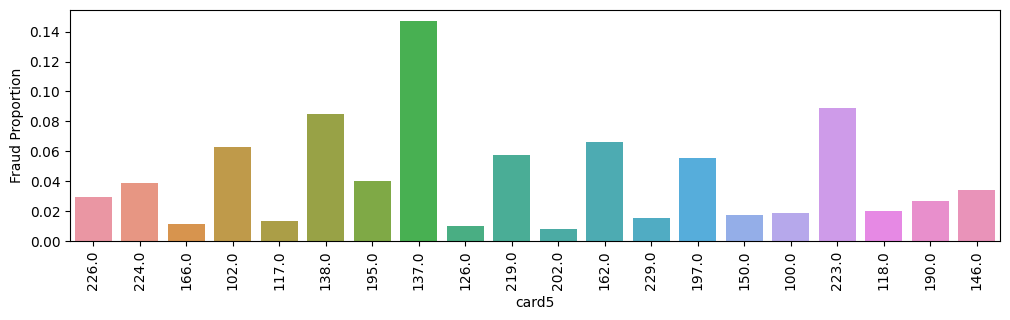

In [11]:
plot_top_fraud_proportion("card5")

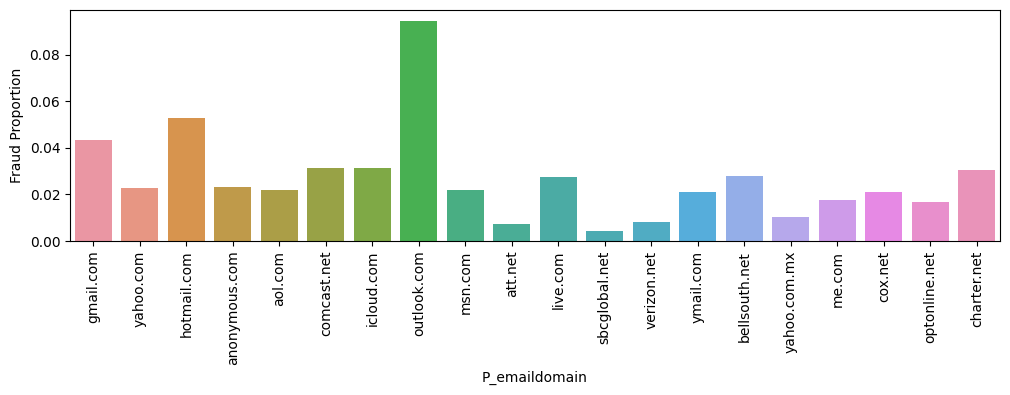

In [12]:
plot_top_fraud_proportion("P_emaildomain")

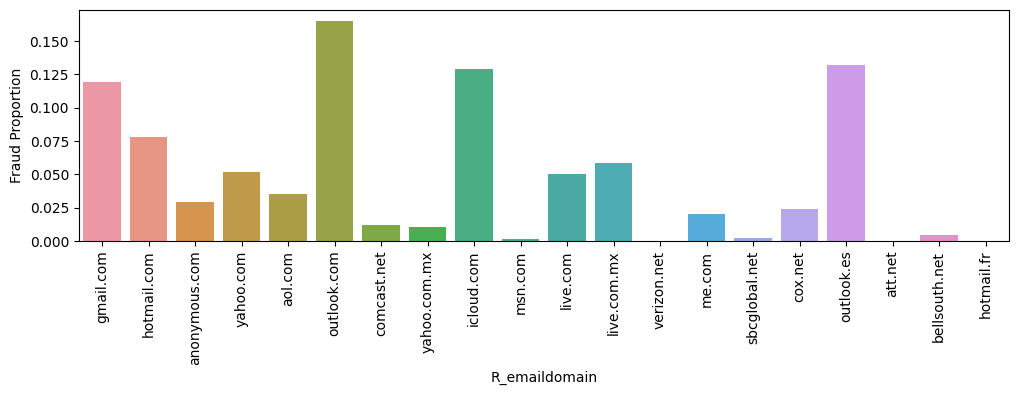

In [13]:
plot_top_fraud_proportion("R_emaildomain")

There are apparent correlations between these variables and the outcome (observed here via the fraud proportion). However, since variable names were obscured in the dataset it's a bit challenging to make very comprehensive interpretations.

Let's encode the categorical variables and save the encoders for later (inference).

In [14]:
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = train_df["isFraud"]
X = train_df.drop(["isFraud", "TransactionID"], axis=1)
print(X.shape)
encoders = {}
for col in categorical_cols:
    encoder = LabelEncoder()
    X[col] = encoder.fit_transform(X[col])
    encoders[col] = {k: i for i, k in enumerate(encoder.classes_.tolist())}

with open("models/encoders.json", "w") as enc_file:
    json.dump(encoders, enc_file)

(590540, 432)


Let's train our model. These hyperparameters produced satisfying results using LightGBM.

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, roc_auc_score
import lightgbm as lgbm


FOLDS = 5


lgbm_params = {
    "n_estimators": 250,
    "random_state": 33,
    "verbose": 0,
}

model = lgbm.LGBMClassifier(**lgbm_params)

splitter = TimeSeriesSplit(n_splits=FOLDS)
score_mean = 0
count = 0
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9)
for train_idx, val_idx in splitter.split(X_train, y_train):
    X_tr, X_vl = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_tr, y_tr)
    score = make_scorer(roc_auc_score, needs_proba=True)(model, X_vl, y_vl)
    score_mean += score
    print(f'{count} CV - score: {round(score, 4)}')
    count += 1

print(f'Mean ROC AUC: {score_mean / FOLDS:.4f}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
0 CV - score: 0.9177
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
1 CV - score: 0.9314
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143462 seconds.
You can set `force_col_wise=true` to remove the overhead.
2 CV - score: 0.9372
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174011 seconds.
You can set `force_col_wise=true` to remove the overhead.
3 CV - score: 0.9448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146332 seconds.
You can set `force_ro

In [16]:
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)
print(f"Validation ROC AUC score: {score:.4f}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Validation ROC AUC score: 0.9500


Let's save the model.

In [17]:
_ = model.booster_.save_model("models/baseline_lgbm.txt")

In [18]:
# loading the model
model_ = lgbm.Booster(model_file="./models/baseline_lgbm.txt")
assert np.allclose(y_pred, model_.predict(X_val))